## Importing necessary libraries and modules
This comprehensive set of imports ensures that we have access to the necessary tools and algorithms for data processing, visualization, and regression modeling in the subsequent steps of the project.

In [ ]:
import requests
from bs4 import BeautifulSoup
import time
import re

from urllib.request import urlopen
from urllib.request import Request
from urllib.error import URLError

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score

import numpy as np
%matplotlib inline
from sklearn.model_selection import train_test_split

## Retrieving Team Data for Multiple Seasons
Retrieves team data for multiple seasons in the English Premier League by scraping web pages and combining the relevant information into a consolidated dataset. The all_matches list will contain the team data for all matches across the specified seasons.

In [ ]:
years = list(range(2022, 2016, -1))  # List of years from 2022 to 2016 in descending order
all_matches = []  # Empty list to store team data for all matches
standings_url = "https://fbref.com/en/comps/9/Premier-League-Stats"  # Initial URL for retrieving standings and team data

# Loop through each year
for year in years:
    data = requests.get(standings_url)  # Fetch the web page content
    soup = BeautifulSoup(data.text)  # Parse the HTML content
    standings_table = soup.select('table.stats_table')[0]  # Select the standings table from HTML
    
    # Extract team URLs from standings table and construct full URLs
    links = [l.get("href") for l in standings_table.find_all('a')]
    links = [l for l in links if '/squads/' in l]
    team_urls = [f"https://fbref.com{l}" for l in links]
    
    previous_season = soup.select("a.prev")[0].get("href")  # Get the URL for the previous season
    standings_url = f"https://fbref.com{previous_season}"  # Update the standings URL
    
    # Iterate through each team URL
    for team_url in team_urls:
        team_name = team_url.split("/")[-1].replace("-Stats", "").replace("-", " ")  # Extract team name from URL
        data = requests.get(team_url)  # Fetch the team data web page
        matches = pd.read_html(data.text, match="Scores & Fixtures")[0]  # Read matches data from HTML
        soup = BeautifulSoup(data.text)
        links = [l.get("href") for l in soup.find_all('a')]
        
        # Data collection for shooting stats
        links_shooting = [l for l in links if l and 'all_comps/shooting/' in l]
        data_shooting = requests.get(f"https://fbref.com{links_shooting[0]}")
        shooting = pd.read_html(data_shooting.text, match="Shooting")[0]
        shooting.columns = shooting.columns.droplevel()
        
        # Data collection for passing stats
        links_passing = [l for l in links if l and 'all_comps/passing/' in l]
        data_passing = requests.get(f"https://fbref.com{links_passing[0]}")
        passing = pd.read_html(data_passing.text, match="Passing")[0]
        passing.columns = passing.columns.droplevel()
        
        # Data collection for possession stats
        links_possession = [l for l in links if l and 'all_comps/possession/' in l]
        data_possession = requests.get(f"https://fbref.com{links_possession[0]}")
        possession = pd.read_html(data_possession.text, match="Possession")[0]
        possession.columns = possession.columns.droplevel()
        
        # Data collection for goal and shot creation stats
        links_gfc = [l for l in links if l and 'all_comps/goal-shot-creation/' in l]
        data_gfc = requests.get(f"https://fbref.com{links_gfc[0]}")
        gfc = pd.read_html(data_gfc.text, match="Goal and Shot Creation")[0]
        gfc.columns = gfc.columns.droplevel()
        
        # Data collection for passing types stats
        links_passing_type = [l for l in links if l and 'all_comps/passing_types/' in l]
        data_passing_type = requests.get(f"https://fbref.com{links_passing_type[0]}")
        passing_type = pd.read_html(data_passing_type.text, match="Pass Types")[0]
        passing_type.columns = passing_type.columns.droplevel()
        
        try:
            # Merge matches and shooting data
            team_data = matches.merge(shooting[["Date", "Sh", "SoT", "Dist", "FK", "PK", "PKatt"]], on="Date")
            # Merge matches and passing data
            team_data = team_data.merge(passing[["Date", "KP", "1/3", "PPA", "CrsPA", "Prog"]], on="Date")
            # Merge matches and possession data
            team_data = team_data.merge(possession[["Date", "Att 3rd", "Att Pen", "Prog"]], on="Date")
            # Merge matches and goal/shot creation data
            team_data = team_data.merge(gfc[["Date", "SCA"]], on="Date")
            # Merge matches and passing types data
            team_data = team_data.merge(passing_type[["Date", "TB"]], on="Date")
        except ValueError:
            continue
        
        team_data = team_data[team_data["Comp"] == "Premier League"]  # Filter for Premier League matches
        team_data["Season"] = year  # Assign current season
        team_data["Team"] = team_name  # Assign team name
        
        all_matches.append(team_data)  # Append team data to the all_matches list
        time.sleep(10)  # Delay to avoid overwhelming the server

## Calculate Season Statistics for a Specific Season

In [ ]:
def season(x):
    # Retrieve data for the specified season
    mainseas = team_data_combined[team_data_combined['Season']==x]
    ass = assists[assists['Season']==x]
    poss = posses[posses['Season']==x]
    cre = creation[creation['Season']==x]
    back = back1[back1['Season']==x]
    
    # Define the list of features to be calculated
    feat = ["Sh", "SoT", "Dist", "FK", "PK", "PKatt", 'GF', 'GA', 'xG', 'xGA', 'Poss', "KP", "1/3", "PPA", "CrsPA", "Prog",
            "Att 3rd", "Att Pen", "Prog", 'SCA', 'TB']
    
    # Create an empty DataFrame with the team names
    df = pd.DataFrame()
    df['Team'] = mainseas['Team'].unique()
    
    # Initialize the columns of the DataFrame with zeros
    for i in feat:
        df[i] = 0.0
        
    # Define subgroups of features
    main = ["Sh", "SoT", "Dist", "FK", "PK", "PKatt", 'GF', 'GA', 'xG', 'xGA', 'Poss']
    asss = ["KP", "1/3", "PPA", "CrsPA", "Prog"]
    posss = ["Att 3rd", "Att Pen", "Prog"]
    gfc = ['SCA']
    tb = ['TB']
    
    # List of tables corresponding to each subgroup of features
    tables = [mainseas, ass, poss, cre, back]
    
    # Calculate the mean value for each feature in the main subgroup
    for j in main:
        for i in range(len(df)):
            df[j][i] = mainseas[mainseas['Team'] == df['Team'][i]][j].mean()
                
    # Calculate the mean value for each feature in the assists subgroup
    for j in asss:
        for i in range(len(df)):
            df[j][i] = ass[ass['Team'] == df['Team'][i]][j].mean()
                
    # Calculate the mean value for each feature in the possession subgroup
    for j in posss:
        for i in range(len(df)):
            df[j][i] = poss[poss['Team'] == df['Team'][i]][j].mean()
    
    # Calculate the mean value for the goal and shot creation feature
    for i in range(len(df)):
        df['SCA'][i] = cre[cre['Team'] == df['Team'][i]]['SCA'].mean()
    
    # Calculate the mean value for the pass types feature
    for i in range(len(df)):
        df['TB'][i] = back[back['Team'] == df['Team'][i]]['TB'].mean()
            
    # Add season, points, and points per match columns to the DataFrame
    df['Season'] = x
    df['Points'] = 0
    df['Points per match'] = 0.0
    
    # Calculate the points and points per match for each team
    for i in range(len(df)):
        df['Points'][i] = mainseas[mainseas['Team'] == df['Team'][i]]['Result'].value_counts()['W']*3 + mainseas[mainseas['Team'] == df['Team'][i]]['Result'].value_counts()['D']
        df['Points per match'][i] = df['Points'][i] / len(mainseas[mainseas['Team'] == df['Team'][i]])
    
    return df

# Calculation of Season Statistics for Different Seasons

In [ ]:
# Calculate season statistics for the year 2020
seas20 = season(2020)

# Calculate season statistics for the year 2019
seas19 = season(2019)

# Calculate season statistics for the year 2022
seas22 = season(2022)

# Calculate season statistics for the year 2017
seas17 = season(2017)

# Calculate season statistics for the year 2018
seas18 = season(2018)

# Calculate season statistics for the year 2021
seas21 = season(2021)

# Concatenate season DataFrames
total = pd.concat([seas19,seas20,seas21,seas17,seas18])

In [3]:
total

,Team,Sh,SoT,Dist,FK,PK,PKatt,GF,GA,xG,...,PPA,CrsPA,Prog,Att 3rd,Att Pen,SCA,TB,Season,Points,Points per match
0,Manchester City,17.263158,6.684211,17.805263,0.789474,0.157895,0.210526,2.789474,0.710526,2.065789,...,13.815789,1.157895,45.447368,253.605263,32.894737,31.815789,3.105263,2017,100,2.631579
1,Manchester United,13.394737,4.473684,18.055263,0.552632,0.026316,0.078947,1.789474,0.736842,1.468421,...,9.394737,1.921053,30.736842,185.026316,23.447368,24.105263,2.236842,2017,81,2.131579
2,Tottenham Hotspur,16.315789,5.500000,18.568421,0.736842,0.052632,0.078947,1.947368,0.947368,1.700000,...,10.368421,1.657895,43.421053,194.184211,24.684211,28.710526,2.184211,2017,77,2.026316
3,Liverpool,16.710526,5.947368,17.600000,0.578947,0.052632,0.078947,2.210526,1.000000,1.913158,...,12.210526,1.763158,45.657895,189.710526,27.789474,29.947368,2.789474,2017,75,1.973684
4,Chelsea,15.868421,5.526316,17.518421,0.526316,0.078947,0.078947,1.631579,1.000000,1.423684,...,10.473684,1.947368,36.710526,190.921053,26.105263,29.342105,1.815789,2017,70,1.842105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Everton,11.315789,3.421053,17.918421,0.473684,0.157895,0.184211,1.131579,1.736842,1.250000,...,6.710526,2.026316,20.631579,129.789474,19.078947,19.500000,0.789474,2021,39,1.026316
96,Leeds United,12.631579,3.736842,18.552632,0.342105,0.131579,0.131579,1.105263,2.078947,1.328947,...,7.157895,1.394737,28.342105,127.447368,20.526316,21.684211,1.736842,2021,38,1.000000
97,Burnley,10.657895,3.131579,17.452632,0.368421,0.026316,0.052632,0.894737,1.394737,1.152632,...,6.315789,2.210526,18.631579,122.078947,17.342105,17.736842,0.842105,2021,35,0.921053
98,Watford,10.447368,3.236842,18.302632,0.631579,0.026316,0.052632,0.894737,2.026316,1.163158,...,5.605263,1.842105,19.842105,112.394737,16.078947,18.210526,0.921053,2021,23,0.605263


# Correlation Heatmap of Selected Variables in the English Premier League (EPL) Seasons

<AxesSubplot:>

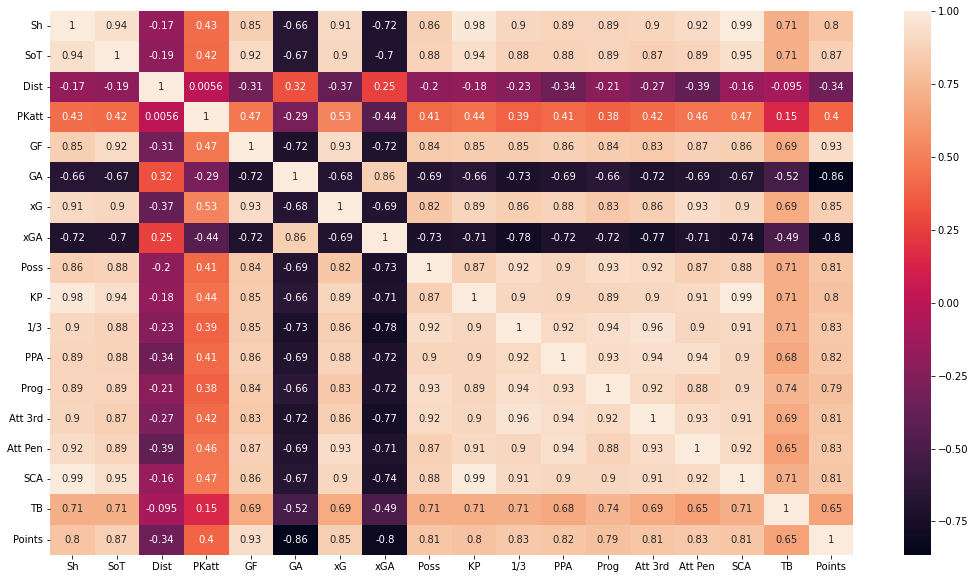

In [4]:
fig, ax = plt.subplots(figsize=(18,10))
sns.heatmap(total.drop(['CrsPA','Season','Team','FK','PK','Points per match'],axis=1).corr(),annot=True,)

# Machine Learning Regression Models for Predicting EPL Team Points
Preparing the data for training and testing regression models to predict EPL team points
Splitting the data: Dividing the dataset into input features (X) and target variable (y). We exclude the 'Points', 'Season', 'Team', and 'Points per match' columns from the input features. Also spliting the data into training and testing sets using a test size of 0.2 and a random state of 42.

Preparing the test data: Removing the same columns from the 'seas22' dataset to create the test data for the 2022 season.

Initializing regression models: Creating instances of various regression models, including K Nearest Neighbors (KNN), Decision Tree, Random Forest, AdaBoost, Gradient Boosting Regressor, XGBRegressor, and CatBoostRegressor. Each model is associated with a name and a corresponding object.

In [5]:
# Splitting the data into input features (X) and target variable (y)
X = total.drop(['Points', 'Season', 'Team', 'Points per match'], axis=1)
y = total['Points']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preparing the test data for the 2022 season
seas22_test = seas22.drop(['Points', 'Season', 'Team', 'Points per match'], axis=1)

In [ ]:
# Initializing regression models
knn = KNeighborsRegressor(n_neighbors=8)
dt = DecisionTreeRegressor(max_depth=5)
rf = RandomForestRegressor(n_estimators=100, max_features=7)
ada = AdaBoostRegressor(n_estimators=150, learning_rate=.08)
gbr = GradientBoostingRegressor(max_depth=7, n_estimators=500, learning_rate=.05)
xgb = XGBRegressor(max_depth=7, n_estimators=500, learning_rate=.05)
cb = CatBoostRegressor(learning_rate=.07, max_depth=7, verbose=0)

regressors = [
    ('K Nearest Neighbours', knn),
    ('Decision Tree', dt),
    ('Random Forest', rf),
    ('AdaBoost', ada),
    ('Gradient Boosting Regressor', gbr),
    ('XGBRegressor', xgb),
    ('CatBoostRegressor', cb)

K Nearest Neighbours : 68 %
Decision Tree : 84 %
Random Forest : 92 %
AdaBoost : 95 %
Gradient Boosting Regressor : 87 %
XGBRegressor : 93 %
CatBoostRegressor : 82 %


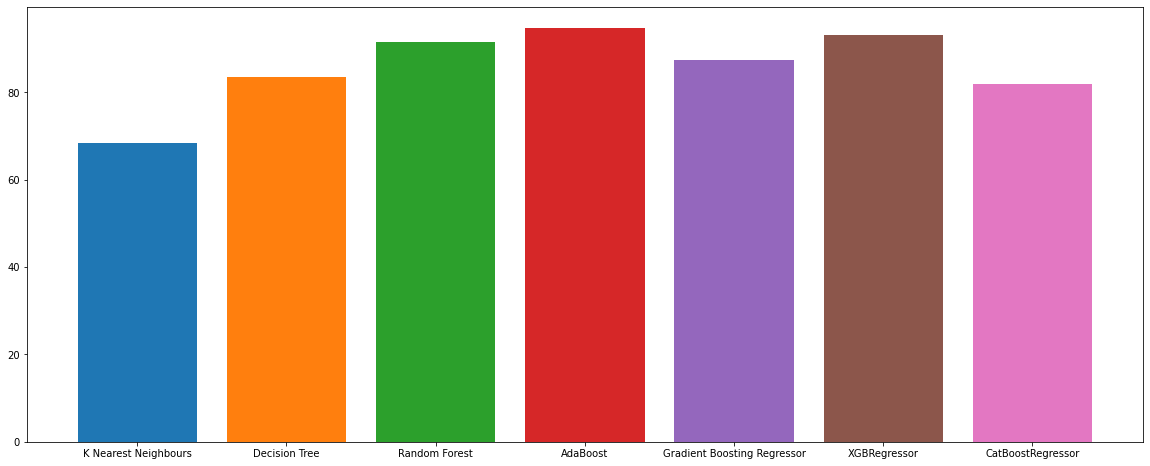

In [8]:
# Iterate over each regressor in the list
for regressor_name, regressor in regressors:
    # Fit the regressor to the training data
    regressor.fit(X_train, y_train)
    
    # Predict the target variable using the test data
    y_pred = regressor.predict(X_test)
    
    # Calculate the accuracy of the model using R-squared score and round it to 3 decimal places
    accuracy = round(r2_score(y_test, y_pred), 3) * 100
    
    # Print the accuracy of the model along with the regressor name
    print('{:s} : {:.0f} %'.format(regressor_name, accuracy))
    
    # Adjust the figure size for better visualization
    plt.rcParams["figure.figsize"] = (20, 8)
    
    # Plot a bar chart representing the accuracy of each regressor
    plt.bar(regressor_name, accuracy)

# Generating Predictions for 2022 Season using Regressors

In [9]:
# Create a copy of 'seas22'
seas22_predictions = seas22

# Iterate over each regressor in the 'regressors' list
for regressor_name, regressor in regressors:
    # Predict the target variable for 'seas22_test' using the current regressor
    y_pred = regressor.predict(seas22_test)
    
    # Add the predicted values as a new column with the regressor name in 'seas22_predictions'
    seas22_predictions[regressor_name] = y_pred
    
    # Add a new column with the regressor name and 'PPg' suffix, representing predicted points per game
    seas22_predictions[f"{regressor_name} PPg"] = y_pred / 38
    
    # Drop the unnecessary columns from 'seas22_predictions'
    seas22_predictions.drop(['Sh', 'SoT', 'Dist', 'FK', 'PK', 'PKatt', 'GF', 'GA', 'xG',
                             'xGA', 'Poss', 'KP', '1/3', 'PPA', 'CrsPA', 'Prog', 'Att 3rd',
                             'Att Pen', 'SCA', 'TB'], axis=1, inplace=True)


In [10]:
seas22_predictions.drop(['Sh', 'SoT', 'Dist', 'FK', 'PK', 'PKatt', 'GF', 'GA', 'xG',
       'xGA', 'Poss', 'KP', '1/3', 'PPA', 'CrsPA', 'Prog', 'Att 3rd',
       'Att Pen', 'SCA', 'TB'],axis=1,inplace=True)

In [11]:
seas22_predictions

,Team,Season,Points,Points per match,K Nearest Neighbours,K Nearest Neighbours PPg,Decision Tree,Decision Tree PPg,Random Forest,Random Forest PPg,AdaBoost,AdaBoost PPg,Gradient Boosting Regressor,Gradient Boosting Regressor PPg,XGBRegressor,XGBRegressor PPg,CatBoostRegressor,CatBoostRegressor PPg
0,Arsenal,2022,37,2.642857,78.625,2.069079,98.000000,2.578947,84.50,2.223684,95.400000,2.510526,95.303191,2.507979,97.064796,2.554337,86.113803,2.266153
1,Manchester City,2022,32,2.285714,82.750,2.177632,75.000000,1.973684,85.95,2.261842,83.000000,2.184211,73.045266,1.922244,88.151802,2.319784,85.209557,2.242357
2,Newcastle United,2022,30,2.000000,62.500,1.644737,98.000000,2.578947,73.97,1.946579,75.875000,1.996711,90.887985,2.391789,78.422432,2.063748,76.650310,2.017113
3,Tottenham Hotspur,2022,29,1.933333,50.125,1.319079,68.875000,1.812500,66.06,1.738421,64.916667,1.708333,66.555932,1.751472,63.367584,1.667568,61.274189,1.612479
4,Manchester United,2022,26,1.857143,56.500,1.486842,47.300000,1.244737,55.30,1.455263,51.228571,1.348120,45.133811,1.187732,47.476658,1.249386,52.505267,1.381718
5,Liverpool,2022,22,1.571429,78.625,2.069079,75.000000,1.973684,80.65,2.122368,71.312500,1.876645,73.682764,1.939020,70.071175,1.843978,71.310219,1.876585
6,Brighton and Hove Albion,2022,21,1.500000,68.625,1.805921,68.875000,1.812500,66.39,1.747105,66.764706,1.756966,67.738175,1.782584,63.690033,1.676054,67.972261,1.788744
7,Chelsea,2022,21,1.500000,68.625,1.805921,57.142857,1.503759,55.74,1.466842,53.000000,1.394737,57.078037,1.502054,56.452412,1.485590,55.326202,1.455953
8,Fulham,2022,19,1.266667,47.625,1.253289,52.000000,1.368421,45.85,1.206579,46.642857,1.227444,54.463213,1.433242,43.533638,1.145622,48.870489,1.286065
9,Brentford,2022,19,1.266667,41.250,1.085526,68.875000,1.812500,48.61,1.279211,47.357143,1.246241,65.786090,1.731213,46.140198,1.214216,49.973848,1.315101


## Predicted Points Calculation for Different Regressors
The code below calculates the predicted points for each team in the `seas22_predictions` dataframe using different regression models. The predicted points are based on the points per game (PPg) values generated by the respective regressor model. 

In [12]:
seas22_predictions['Predicted Points XGB']=0.0
for i in range(len(seas22_predictions['Team'].unique())):
    seas22_predictions['Predicted Points XGB'][i]=seas22_predictions['XGBRegressor PPg'][i]*(38-len(fix[(fix['Team']==seas22_predictions['Team'][i])&(fix['Season']==2022)]))+seas22_predictions['Points'][i]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
seas22_predictions['Predicted Points AdaBoost']=0.0
for i in range(len(seas22_predictions['Team'].unique())):
    seas22_predictions['Predicted Points AdaBoost'][i]=seas22_predictions['AdaBoost PPg'][i]*(38-len(fix[(fix['Team']==seas22_predictions['Team'][i])&(fix['Season']==2022)]))+seas22_predictions['Points'][i]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
seas22_predictions['Predicted Points Random Forest']=0.0
for i in range(len(seas22_predictions['Team'].unique())):
    seas22_predictions['Predicted Points Random Forest'][i]=seas22_predictions['Random Forest PPg'][i]*(38-len(fix[(fix['Team']==seas22_predictions['Team'][i])&(fix['Season']==2022)]))+seas22_predictions['Points'][i]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Predicted Points for EPL 2022 Season

In [15]:
seas22_filtered=seas22_predictions
seas22_filtered[['Predicted Points XGB','Predicted Points AdaBoost','Predicted Points Random Forest']]=seas22_filtered[['Predicted Points XGB','Predicted Points AdaBoost','Predicted Points Random Forest']].astype(int)

In [17]:
seas22_filtered.sort_values('Predicted Points XGB',ascending=False)[['Team','Season','Predicted Points XGB']]

,Team,Season,Predicted Points XGB
0,Arsenal,2022,98
1,Manchester City,2022,87
2,Newcastle United,2022,77
3,Tottenham Hotspur,2022,67
5,Liverpool,2022,66
6,Brighton and Hove Albion,2022,61
7,Chelsea,2022,56
4,Manchester United,2022,55
10,Crystal Palace,2022,51
14,Leeds United,2022,47


In [18]:
seas22_filtered.sort_values('Predicted Points AdaBoost',ascending=False)[['Team','Season','Predicted Points AdaBoost']]

,Team,Season,Predicted Points AdaBoost
0,Arsenal,2022,97
1,Manchester City,2022,84
2,Newcastle United,2022,75
3,Tottenham Hotspur,2022,68
5,Liverpool,2022,67
6,Brighton and Hove Albion,2022,63
4,Manchester United,2022,58
7,Chelsea,2022,54
14,Leeds United,2022,52
10,Crystal Palace,2022,49


In [19]:
seas22_filtered.sort_values('Predicted Points Random Forest',ascending=False)[['Team','Season','Predicted Points Random Forest']]

,Team,Season,Predicted Points Random Forest
0,Arsenal,2022,90
1,Manchester City,2022,86
2,Newcastle United,2022,74
5,Liverpool,2022,72
3,Tottenham Hotspur,2022,68
6,Brighton and Hove Albion,2022,62
4,Manchester United,2022,60
7,Chelsea,2022,56
14,Leeds United,2022,50
10,Crystal Palace,2022,49


The overall prediction remains consistent, with Arsenal projected to finish first with over 89 points. Newcastle consistently secures the third position due to their strong performance statistics in the current season. It is worth noting that teams like Chelsea and Manchester United fare poorly in the prediction due to their lower performance indicators, despite their higher positions than Brighton and Liverpool in the current stage of the season. This could be attributed to Arsenal and Newcastle overachieving in terms of points at this stage of the season. Additionally, Arsenal's impressive performance averages, nearing championship-level per game statistics, coupled with their existing points, contribute to their predicted title win.